In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
## Dependencies

!pip install einops --quiet

In [3]:
## importing essential packages and configuring them
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
import math

In [4]:
## Bezier curve + dataset

def bezier_curve(P, n=100):
    t = torch.linspace(0, 1, n).unsqueeze(1)
    return ((1 - t)**3) * P[0] + \
           3 * ((1 - t)**2) * t * P[1] + \
           3 * (1 - t) * t**2 * P[2] + \
           t**3 * P[3]

class BezierDataset(Dataset):
    def __init__(self, num_samples=10000):
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Random control points in [0, 1]
        control_points = torch.rand(4, 2) * 2 - 1  # range [-1, 1]
        return control_points.flatten()  # shape: (8,)

In [28]:
## diffusion process (U-NET ARCHITECTURE + GAUSSIAN NOISE)

class GaussianDiffusion:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02):
        self.timesteps = timesteps
        def cosine_beta_schedule(timesteps, s=0.0001):
            steps = timesteps + 1
            x = torch.linspace(0, timesteps, steps)
            alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
            alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
            betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
            return torch.clamp(betas, 0.0001, 0.9999)

            # In __init__
        self.beta = cosine_beta_schedule(timesteps)

        #self.beta = torch.linspace(beta_start, beta_end, timesteps)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        
        device = x_start.device  # ensure everything is on the same device
        alpha_hat = self.alpha_hat.to(device)
    
        sqrt_alpha_hat = alpha_hat[t]**0.5
        sqrt_one_minus_alpha_hat = (1 - alpha_hat[t])**0.5
    
        return sqrt_alpha_hat[:, None] * x_start + sqrt_one_minus_alpha_hat[:, None] * noise

    def predict_start_from_noise(self, x_t, t, noise):
        device = x_t.device
        alpha_hat = self.alpha_hat.to(device)
        return (x_t - (1 - alpha_hat[t])[:, None].sqrt() * noise) / alpha_hat[t][:, None].sqrt()


In [30]:
import math
import torch.nn as nn

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]  # [B, dim//2]
        emb = torch.cat([emb.sin(), emb.cos()], dim=-1)  # [B, dim]
        return emb


In [36]:
## EMA Averaging

class EMA:
    def __init__(self, model, beta=0.995):
        self.model = model
        self.shadow = {k: v.clone().detach() for k, v in model.state_dict().items()}
        self.beta = beta

    def update(self):
        for name, param in self.model.state_dict().items():
            if name in self.shadow:
                self.shadow[name].data.copy_(
                    self.beta * self.shadow[name].data + (1. - self.beta) * param.data
                )

    def copy_to(self, model_target):
        model_target.load_state_dict(self.shadow)

In [31]:
class BezierDenoiser(nn.Module):
    def __init__(self, dim=256):
        super().__init__()

        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(32),
            nn.Linear(32, dim),
            nn.ReLU()
        )

        self.net = nn.Sequential(
            nn.Linear(8 + dim, dim),
            nn.LayerNorm(dim),
            nn.GELU(),
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
            nn.GELU(),
            nn.Linear(dim, 8),
        )

    def forward(self, x, t):
        # t: [B]  → embed → [B, dim]
        t_emb = self.time_mlp(t)
        x = torch.cat([x, t_emb], dim=1)
        return self.net(x)


In [32]:
## training loop

class BezierDenoiser(nn.Module):
    def __init__(self, dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(8 + 1, dim),
            nn.ReLU(),
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, 8),
        )

    def forward(self, x, t):
        # Embed timestep t
        t = t.float().unsqueeze(1) / 1000
        x_in = torch.cat([x, t], dim=1)
        return self.net(x_in)

In [39]:
def train_diffusion_model():
    dataset = BezierDataset()
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    model = BezierDenoiser().cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    diffusion = GaussianDiffusion()
    ema = EMA(model)

    for epoch in range(50):
        for x0 in dataloader:
            x0 = x0.cuda()
            t = torch.randint(0, diffusion.timesteps, (x0.size(0),)).cuda()
            noise = torch.randn_like(x0)
            x_noisy = diffusion.q_sample(x0, t, noise)
            
            noise_pred = model(x_noisy, t)
            loss = F.mse_loss(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ema.update()  # ← EMA updated every batch

        print(f"Epoch {epoch} - Loss: {loss.item():.4f}")
    
    # Save final model & EMA state
    torch.save(model.state_dict(), "bezier_model.pt")
    torch.save(ema.shadow, "bezier_model_ema.pt")


In [40]:
## Sampling and Visulaisation

def sample(model, diffusion, num_samples=10):
    model.eval()
    x = torch.randn(num_samples, 8).cuda()

    for t in reversed(range(diffusion.timesteps)):
        t_batch = torch.full((num_samples,), t).cuda()
        noise_pred = model(x, t_batch)
        beta_t = diffusion.beta[t]
        alpha_t = diffusion.alpha[t]
        alpha_hat_t = diffusion.alpha_hat[t]

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (1 / alpha_t**0.5) * (x - (1 - alpha_t) / (1 - alpha_hat_t).sqrt() * noise_pred) + beta_t**0.5 * noise

    return x.cpu().detach()

def plot_bezier_samples(control_point_tensor, n_curves=5):
    plt.figure(figsize=(10, 5))
    for i in range(n_curves):
        cp = control_point_tensor[i].view(4, 2)
        curve = bezier_curve(cp)
        plt.plot(curve[:, 0], curve[:, 1], linewidth=2)
        plt.scatter(cp[:, 0], cp[:, 1], c='red', alpha=0.3)
    plt.title("Generated Bezier Curves")
    plt.axis('equal')
    plt.grid(True)
    plt.show()


In [41]:
## training the model
train_diffusion_model()

Epoch 0 - Loss: 0.5149
Epoch 1 - Loss: 0.2727
Epoch 2 - Loss: 0.3418
Epoch 3 - Loss: 0.4424
Epoch 4 - Loss: 0.4372
Epoch 5 - Loss: 0.3106
Epoch 6 - Loss: 0.3933
Epoch 7 - Loss: 0.3337
Epoch 8 - Loss: 0.6121
Epoch 9 - Loss: 0.3993
Epoch 10 - Loss: 0.2879
Epoch 11 - Loss: 0.2589
Epoch 12 - Loss: 0.3196
Epoch 13 - Loss: 0.4023
Epoch 14 - Loss: 0.3476
Epoch 15 - Loss: 0.4918
Epoch 16 - Loss: 0.3469
Epoch 17 - Loss: 0.4462
Epoch 18 - Loss: 0.3898
Epoch 19 - Loss: 0.4538
Epoch 20 - Loss: 0.2437
Epoch 21 - Loss: 0.4584
Epoch 22 - Loss: 0.6325
Epoch 23 - Loss: 0.1805
Epoch 24 - Loss: 0.2704
Epoch 25 - Loss: 0.3627
Epoch 26 - Loss: 0.4858
Epoch 27 - Loss: 0.3234
Epoch 28 - Loss: 0.4276
Epoch 29 - Loss: 0.2609
Epoch 30 - Loss: 0.4132
Epoch 31 - Loss: 0.5103
Epoch 32 - Loss: 0.2349
Epoch 33 - Loss: 0.2956
Epoch 34 - Loss: 0.4119
Epoch 35 - Loss: 0.2848
Epoch 36 - Loss: 0.3497
Epoch 37 - Loss: 0.4987
Epoch 38 - Loss: 0.3098
Epoch 39 - Loss: 0.2653
Epoch 40 - Loss: 0.5227
Epoch 41 - Loss: 0.3367
Ep

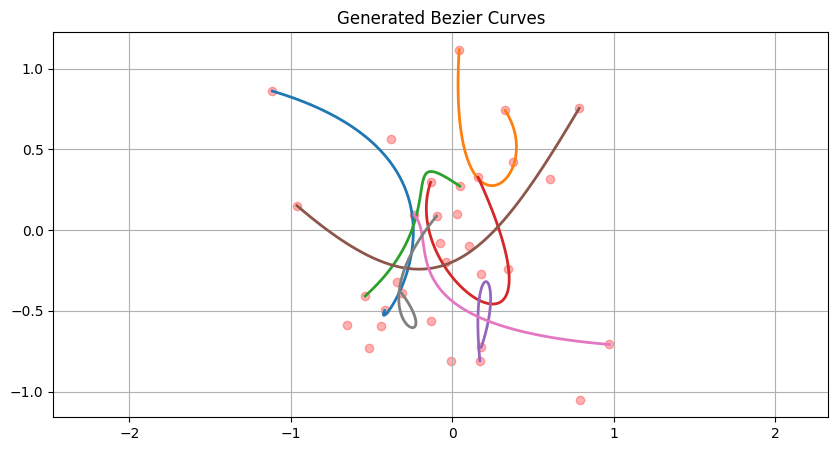

In [43]:
## Bezier curve implementation

model = BezierDenoiser().cuda()
ema_params = torch.load("bezier_model_ema.pt")
model.load_state_dict(ema_params)
model.eval()

diffusion = GaussianDiffusion()
samples = sample(model, diffusion, num_samples=8)
plot_bezier_samples(samples, n_curves=8)

Loaded 144722 samples of class 'apple'


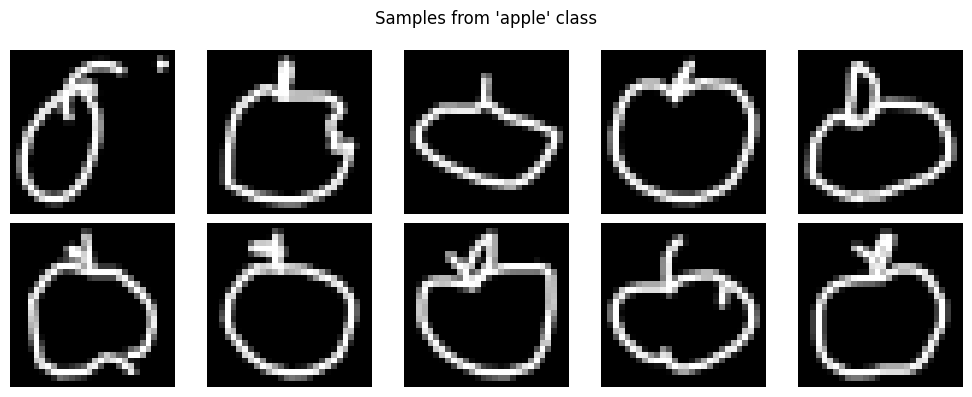

In [47]:
######## Now using standard dataset

import numpy as np
import matplotlib.pyplot as plt
import os

# Set the path to the dataset
data_dir = "/kaggle/input/quickdraw-full"
class_name = "apple"
file_path = os.path.join(data_dir, f"{class_name}.npy")

# Load data
data = np.load(file_path)
print(f"Loaded {data.shape[0]} samples of class '{class_name}'")

# Normalize and visualize a few samples
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(data[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle(f"Samples from '{class_name}' class")
plt.tight_layout()
plt.show()


In [48]:
## Extracting bezier curve from bitmaps

import cv2
from scipy.interpolate import splprep, splev

def extract_bezier_control_points(image, max_curves=10):
    """
    Given a 28x28 grayscale image, extract bezier curve control points.
    """
    # Binarize the image
    thresh_img = (image > 0.5).astype(np.uint8) * 255
    
    # Find contours
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    curves = []

    for cnt in contours:
        cnt = cnt.squeeze()
        if len(cnt.shape) != 2 or cnt.shape[0] < 4:
            continue

        # Fit spline and sample points along the contour
        try:
            tck, _ = splprep([cnt[:, 0], cnt[:, 1]], s=2)
            u = np.linspace(0, 1, 20)
            x_new, y_new = splev(u, tck)
            sampled = np.vstack([x_new, y_new]).T

            # Form Bezier curves (every 4 points = 1 cubic Bezier)
            for i in range(0, len(sampled) - 3, 3):
                bezier = sampled[i:i+4]
                if bezier.shape[0] == 4:
                    curves.append(bezier)

                if len(curves) >= max_curves:
                    break
        except:
            continue

    return np.array(curves)

In [49]:
def plot_bezier_curves(bezier_curves, ax=None):
    from matplotlib.path import Path
    from matplotlib.patches import PathPatch
    if ax is None:
        fig, ax = plt.subplots()

    colors = plt.cm.tab10(np.linspace(0, 1, len(bezier_curves)))
    for curve, color in zip(bezier_curves, colors):
        path_data = [
            (Path.MOVETO, curve[0]),
            (Path.CURVE4, curve[1]),
            (Path.CURVE4, curve[2]),
            (Path.CURVE4, curve[3])
        ]
        codes, verts = zip(*path_data)
        path = Path(verts, codes)
        patch = PathPatch(path, facecolor='none', lw=2, edgecolor=color)
        ax.add_patch(patch)
    ax.set_xlim(0, 28)
    ax.set_ylim(28, 0)
    ax.set_aspect('equal')
    ax.axis('off')

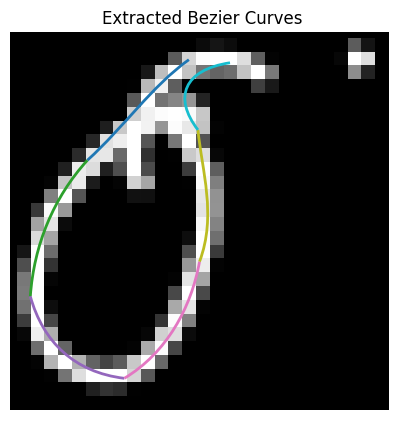

In [50]:
sample_img = data[0].reshape(28, 28) / 255.0
curves = extract_bezier_control_points(sample_img)

# Plot result
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(sample_img, cmap='gray')
plot_bezier_curves(curves, ax)
plt.title("Extracted Bezier Curves")
plt.show()

In [51]:
## dataset builder

class BezierCurveDataset(torch.utils.data.Dataset):
    def __init__(self, images, num_curves=10):
        self.images = images
        self.num_curves = num_curves

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx].reshape(28, 28) / 255.0
        curves = extract_bezier_control_points(img, max_curves=self.num_curves)

        # Padding/truncation
        if len(curves) < self.num_curves:
            pad = np.zeros((self.num_curves - len(curves), 4, 2))
            curves = np.concatenate([curves, pad], axis=0)
        else:
            curves = curves[:self.num_curves]

        return torch.tensor(curves, dtype=torch.float32)

In [52]:
# Convert numpy array to torch-compatible dataset
dataset = BezierCurveDataset(data[:1000], num_curves=10)

# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

# Preview a batch shape
for batch in dataloader:
    print("Batch shape:", batch.shape)  # Should be [64, 10, 4, 2]
    break

Batch shape: torch.Size([64, 10, 4, 2])


In [53]:
## MLP with timestep embedding

class TimestepMLP(nn.Module):
    def __init__(self, input_dim=80, hidden_dim=256, time_embed_dim=128):
        super().__init__()
        self.input_dim = input_dim
        self.time_embed = nn.Sequential(
            nn.Linear(1, time_embed_dim),
            nn.ReLU(),
            nn.Linear(time_embed_dim, input_dim)
        )
        self.model = nn.Sequential(
            nn.Linear(input_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, t):
        # x: [B, 80], t: [B]
        t_embed = self.time_embed(t.unsqueeze(-1).float() / 1000)  # Normalize t
        x_in = torch.cat([x, t_embed], dim=-1)
        return self.model(x_in)

In [57]:
## Diffusion class
class BezierDiffusion:
    def __init__(self, timesteps=1000, device="cuda"):
        self.timesteps = timesteps
        beta = torch.linspace(1e-4, 0.02, timesteps).to(device)
        self.alpha = 1 - beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
        self.device = device

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alpha_hat = self.alpha_hat[t].sqrt().unsqueeze(-1)
        sqrt_one_minus_alpha_hat = (1 - self.alpha_hat[t]).sqrt().unsqueeze(-1)
        return sqrt_alpha_hat * x_start + sqrt_one_minus_alpha_hat * noise


In [55]:
## Training  loop
def train_bezier_diffusion_model(dataloader, model, diffusion, epochs=50):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    model.train()

    for epoch in range(epochs):
        losses = []
        for batch in dataloader:
            batch = batch.view(batch.size(0), -1).cuda()  # Flatten to [B, 80]
            t = torch.randint(0, diffusion.timesteps, (batch.size(0),)).cuda()
            noise = torch.randn_like(batch)
            x_noisy = diffusion.q_sample(batch, t, noise)

            noise_pred = model(x_noisy, t)
            loss = F.mse_loss(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        print(f"Epoch {epoch} - Loss: {np.mean(losses):.4f}")


In [58]:
## Training
model = TimestepMLP().cuda()
diffusion = BezierDiffusion(timesteps=1000, device="cuda")
train_bezier_diffusion_model(dataloader, model, diffusion, epochs=50)

Epoch 0 - Loss: 1.0123
Epoch 1 - Loss: 0.9755
Epoch 2 - Loss: 0.9269
Epoch 3 - Loss: 0.8375
Epoch 4 - Loss: 0.7642
Epoch 5 - Loss: 0.6840
Epoch 6 - Loss: 0.6320
Epoch 7 - Loss: 0.5893
Epoch 8 - Loss: 0.5437
Epoch 9 - Loss: 0.5048
Epoch 10 - Loss: 0.4592
Epoch 11 - Loss: 0.4441
Epoch 12 - Loss: 0.4125
Epoch 13 - Loss: 0.4222
Epoch 14 - Loss: 0.3839
Epoch 15 - Loss: 0.3649
Epoch 16 - Loss: 0.3748
Epoch 17 - Loss: 0.3669
Epoch 18 - Loss: 0.3359
Epoch 19 - Loss: 0.3461
Epoch 20 - Loss: 0.3406
Epoch 21 - Loss: 0.3321
Epoch 22 - Loss: 0.3149
Epoch 23 - Loss: 0.3235
Epoch 24 - Loss: 0.3157
Epoch 25 - Loss: 0.3115
Epoch 26 - Loss: 0.3076
Epoch 27 - Loss: 0.2971
Epoch 28 - Loss: 0.2961
Epoch 29 - Loss: 0.3069
Epoch 30 - Loss: 0.2999
Epoch 31 - Loss: 0.2913
Epoch 32 - Loss: 0.2928
Epoch 33 - Loss: 0.2715
Epoch 34 - Loss: 0.2889
Epoch 35 - Loss: 0.2938
Epoch 36 - Loss: 0.2941
Epoch 37 - Loss: 0.2705
Epoch 38 - Loss: 0.2902
Epoch 39 - Loss: 0.2682
Epoch 40 - Loss: 0.2967
Epoch 41 - Loss: 0.2810
Ep

In [59]:
##  reverse the process and generate control points from noise

def p_sample(model, x, t, alpha, alpha_hat, device):
    """
    Perform one step of reverse diffusion.
    """
    noise_pred = model(x, t)
    beta_t = 1 - alpha[t]
    alpha_t = alpha[t]
    alpha_hat_t = alpha_hat[t]

    coef1 = 1 / torch.sqrt(alpha_t)
    coef2 = (1 - alpha_t) / torch.sqrt(1 - alpha_hat_t)

    mean = coef1[:, None] * (x - coef2[:, None] * noise_pred)
    noise = torch.randn_like(x) if t[0] > 0 else torch.zeros_like(x)
    std = torch.sqrt(beta_t)
    
    return mean + std[:, None] * noise

In [60]:
## loop to sample over each time step

@torch.no_grad()
def p_sample_loop(model, shape, diffusion, device="cuda"):
    x = torch.randn(shape).to(device)  # Start with pure noise
    for t in reversed(range(diffusion.timesteps)):
        t_tensor = torch.full((shape[0],), t, dtype=torch.long).to(device)
        x = p_sample(model, x, t_tensor, diffusion.alpha, diffusion.alpha_hat, device)
    return x


In [69]:
## decode bezier curve control points

def bezier_curve(points, num_points=20):
    B, N, _ = points.shape
    device = points.device

    if N != 4:
        raise ValueError(f"Bezier curve only supports 4 control points. Got {N}")

    t = torch.linspace(0, 1, num_points, device=device).view(1, -1, 1)

    p0, p1, p2, p3 = points[:, 0], points[:, 1], points[:, 2], points[:, 3]

    curve = (1 - t) ** 3 * p0.unsqueeze(1) + \
            3 * (1 - t) ** 2 * t * p1.unsqueeze(1) + \
            3 * (1 - t) * t ** 2 * p2.unsqueeze(1) + \
            t ** 3 * p3.unsqueeze(1)

    return curve



In [65]:
## Visualise the curve

import matplotlib.pyplot as plt

def render_sampled_curves(sampled_points):
    import matplotlib.pyplot as plt
    for i in range(min(5, len(sampled_points))):
        control_points = sampled_points[i].view(40, 2).unsqueeze(0)  # [1, 40, 2]
        curve = bezier_curve(control_points).squeeze(0).cpu().numpy()
        
        plt.plot(curve[:, 0], -curve[:, 1])  # -y to match drawing convention
        plt.scatter(control_points[0, :, 0].cpu(), -control_points[0, :, 1].cpu(), c='red', s=10)
        plt.title(f"Sample {i+1}")
        plt.axis('equal')
        plt.show()


In [71]:
import matplotlib.pyplot as plt

def render_chained_beziers(sampled_points, num_segments=10):
    for i in range(min(5, len(sampled_points))):
        fig, ax = plt.subplots()
        full_curve = []

        control_points = sampled_points[i].view(num_segments * 4, 2)  # 40 → (10 × 4, 2)

        for j in range(num_segments):
            segment_cp = control_points[j*4:(j+1)*4].unsqueeze(0)  # [1, 4, 2]
            curve = bezier_curve(segment_cp, num_points=20).squeeze(0).cpu().numpy()
            full_curve.append(curve)

            # plot control polygon
            ax.plot(segment_cp[0, :, 0].cpu(), -segment_cp[0, :, 1].cpu(), 'r--', alpha=0.3)
            ax.scatter(segment_cp[0, :, 0].cpu(), -segment_cp[0, :, 1].cpu(), color='red', s=5)

        full_curve = np.concatenate(full_curve, axis=0)
        ax.plot(full_curve[:, 0], -full_curve[:, 1], 'b')
        ax.set_title(f"Sample {i+1}")
        ax.axis('equal')
        plt.show()

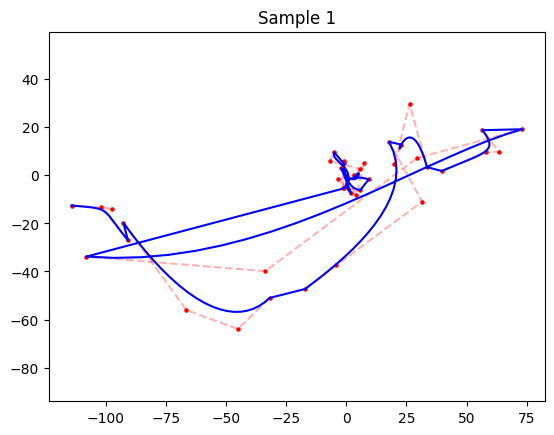

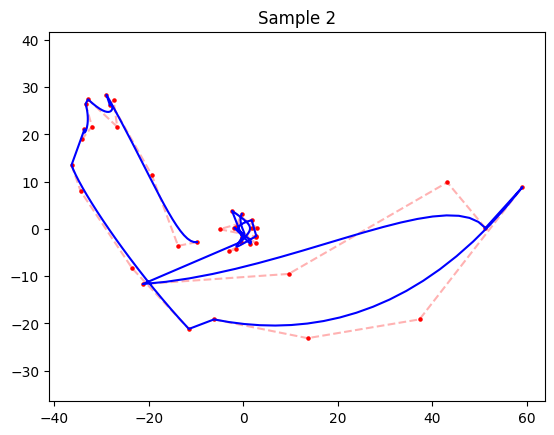

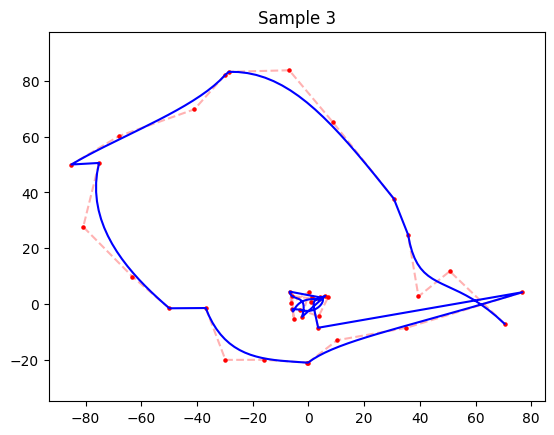

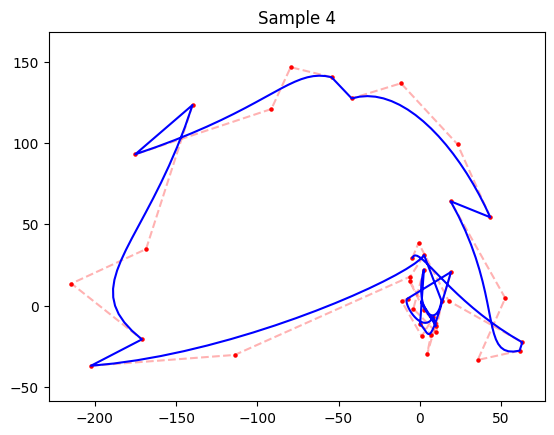

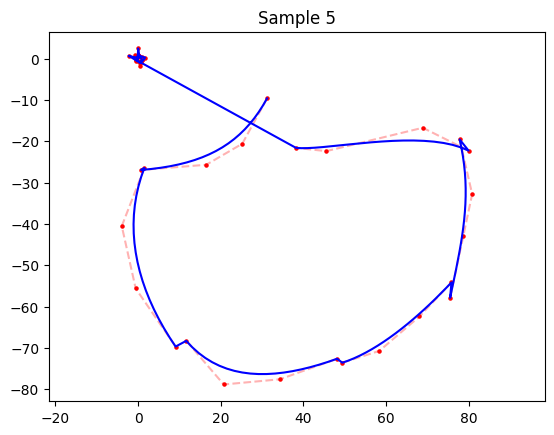

In [73]:
## final rendered o/p
sampled = p_sample_loop(model, shape=(8, 80), diffusion=diffusion)  # [B, 80]
render_chained_beziers(sampled)